<a href="https://colab.research.google.com/github/COS-IT-FLOWS/Impacts/blob/main/Openbuildings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Insert AOI
#@markdown Select a region from either the [Natural Earth low res](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/) (fastest), [Natural Earth high res](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/) or [World Bank high res](https://datacatalog.worldbank.org/dataset/world-bank-official-boundaries) shapefiles:
region_border_source = 'World Bank (High Res 10m)'  #@param ["Natural Earth (Low Res 110m)", "Natural Earth (High Res 10m)", "World Bank (High Res 10m)"]
region = ''  #@param ["", "AGO (Angola)", "BDI (Burundi)", "BEN (Benin)", "BFA (Burkina Faso)", "BGD (Bangladesh)", "BRN (Brunei)", "BTN (Bhutan)", "BWA (Botswana)", "CAF (Central African Republic)", "CIV (C\u00f4te d'Ivoire)", "CMR (Cameroon)", "COD (Democratic Republic of the Congo)", "COG (Republic of the Congo)", "COM (Comoros)", "CPV (Cape Verde)", "DJI (Djibouti)", "DZA (Algeria)", "EGY (Egypt)", "ERI (Eritrea)", "ETH (Ethiopia)", "GAB (Gabon)", "GHA (Ghana)", "GIN (Guinea)", "GMB (The Gambia)", "GNB (Guinea-Bissau)", "GNQ (Equatorial Guinea)", "IDN (Indonesia)", "IOT (British Indian Ocean Territory)", "KEN (Kenya)", "KHM (Cambodia)", "LAO (Laos)", "LBR (Liberia)", "LKA (Sri Lanka)", "LSO (Lesotho)", "MDG (Madagascar)", "MDV (Maldives)", "MOZ (Mozambique)", "MRT (Mauritania)", "MUS (Mauritius)", "MWI (Malawi)", "MYS (Malaysia)", "MYT (Mayotte)", "NAM (Namibia)", "NER (Niger)", "NGA (Nigeria)", "NPL (Nepal)", "PHL (Philippines)", "REU (R\u00e9union)", "RWA (Rwanda)", "SDN (Sudan)", "SEN (Senegal)", "SGP (Singapore)", "SHN (Saint Helena, Ascension and Tristan da Cunha)", "SLE (Sierra Leone)", "SOM (Somalia)", "STP (S\u00e3o Tom\u00e9 and Pr\u00edncipe)", "SWZ (Eswatini)", "SYC (Seychelles)", "TGO (Togo)", "THA (Thailand)", "TLS (Timor-Leste)", "TUN (Tunisia)", "TZA (Tanzania)", "UGA (Uganda)", "VNM (Vietnam)", "ZAF (South Africa)", "ZMB (Zambia)", "ZWE (Zimbabwe)"]

#@markdown Alternatively, specify an area of interest in [WKT format](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) (assumes crs='EPSG:4326'); this [tool](https://arthur-e.github.io/Wicket/sandbox-gmaps3.html) might be useful.
your_own_shapefile_path = "/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp" #@param {type:"string"}
# your_own_wkt_polygon = ''  #@param {type:"string"}
#@markdown Select type of data to download here:
data_type = 'polygons'  #@param ["polygons", "points"]
#@markdown In this analysis we only need centroids of buildings, therefore by default we use the data in the *point* format (files in *polygons* format are larger). Refer to [Open Buildings Data Format](https://sites.research.google/open-buildings/#dataformat) for more details.
!sudo apt-get install swig
!pip install s2geometry pygeos geopandas

import functools
import glob
import gzip
import multiprocessing
import os
import shutil
import tempfile
from typing import List, Optional, Tuple

print(os.getcwd())
import geopandas as gpd
from google.colab import files
from IPython import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s2geometry as s2
import shapely
import tensorflow as tf
import tqdm.notebook

BUILDING_DOWNLOAD_PATH = ('gs://open-buildings-data/v3/'
                          f'{data_type}_s2_level_6_gzip_no_header')

def get_filename_and_region_dataframe(
    region_border_source: str, region: str,
    your_own_shapefile_path: str) -> Tuple[str, gpd.geodataframe.GeoDataFrame]:
  """Returns output filename and a geopandas dataframe with one region row."""
  if your_own_shapefile_path:
    gdf = gpd.read_file(your_own_shapefile_path)
    your_own_wkt_polygon = str(gdf.unary_union)
    print(type(your_own_wkt_polygon))
    filename = f'open_buildings_v3_{data_type}_your_own_wkt_polygon.csv.gz'
    region_df = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries.from_wkt([your_own_wkt_polygon]),
        crs='EPSG:4326')
    if not isinstance(region_df.iloc[0].geometry,
                      shapely.geometry.polygon.Polygon) and not isinstance(
                          region_df.iloc[0].geometry,
                          shapely.geometry.multipolygon.MultiPolygon):
      raise ValueError("`your_own_wkt_polygon` must be a POLYGON or "
                      "MULTIPOLYGON.")
    print(f'Preparing your_own_wkt_polygon.')
    return filename, region_df

  if not region:
    raise ValueError('Please select a region or set your_own_wkt_polygon.')

  if region_border_source == 'Natural Earth (Low Res 110m)':
    url = ('https://www.naturalearthdata.com/http//www.naturalearthdata.com/'
           'download/110m/cultural/ne_110m_admin_0_countries.zip')
    !wget -N {url}
    display.clear_output()
    region_shapefile_path = os.path.basename(url)
    source_name = 'ne_110m'
  elif region_border_source == 'Natural Earth (High Res 10m)':
    url = ('https://www.naturalearthdata.com/http//www.naturalearthdata.com/'
           'download/10m/cultural/ne_10m_admin_0_countries.zip')
    !wget -N {url}
    display.clear_output()
    region_shapefile_path = os.path.basename(url)
    source_name = 'ne_10m'
  elif region_border_source == 'World Bank (High Res 10m)':
    url = ('https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/'
           '779551/wb_countries_admin0_10m.zip')
    !wget -N {url}
    !unzip -o {os.path.basename(url)}
    display.clear_output()
    region_shapefile_path = 'WB_countries_Admin0_10m'
    source_name = 'wb_10m'

  region_iso_a3 = region.split(' ')[0]
  filename = (f'open_buildings_v3_{data_type}_'
              f'{source_name}_{region_iso_a3}.csv.gz')
  region_df = gpd.read_file(region_shapefile_path).query(
      f'ISO_A3 == "{region_iso_a3}"').dissolve(by='ISO_A3')[['geometry']]
  print(f'Preparing {region} from {region_border_source}.')
  return filename, region_df


def get_bounding_box_s2_covering_tokens(
    region_geometry: shapely.geometry.base.BaseGeometry) -> List[str]:
  region_bounds = region_geometry.bounds
  s2_lat_lng_rect = s2.S2LatLngRect_FromPointPair(
      s2.S2LatLng_FromDegrees(region_bounds[1], region_bounds[0]),
      s2.S2LatLng_FromDegrees(region_bounds[3], region_bounds[2]))
  coverer = s2.S2RegionCoverer()
  # NOTE: Should be kept in-sync with s2 level in BUILDING_DOWNLOAD_PATH.
  coverer.set_fixed_level(6)
  coverer.set_max_cells(1000000)
  return [cell.ToToken() for cell in coverer.GetCovering(s2_lat_lng_rect)]


def s2_token_to_shapely_polygon(
    s2_token: str) -> shapely.geometry.polygon.Polygon:
  s2_cell = s2.S2Cell(s2.S2CellId_FromToken(s2_token, len(s2_token)))
  coords = []
  for i in range(4):
    s2_lat_lng = s2.S2LatLng(s2_cell.GetVertex(i))
    coords.append((s2_lat_lng.lng().degrees(), s2_lat_lng.lat().degrees()))
  return shapely.geometry.Polygon(coords)


def download_s2_token(
    s2_token: str, region_df: gpd.geodataframe.GeoDataFrame) -> Optional[str]:
  """Downloads the matching CSV file with polygons for the `s2_token`.

  NOTE: Only polygons inside the region are kept.
  NOTE: Passing output via a temporary file to reduce memory usage.

  Args:
    s2_token: S2 token for which to download the CSV file with building
      polygons. The S2 token should be at the same level as the files in
      BUILDING_DOWNLOAD_PATH.
    region_df: A geopandas dataframe with only one row that contains the region
      for which to keep polygons.

  Returns:
    Either filepath which contains a gzipped CSV without header for the
    `s2_token` subfiltered to only contain building polygons inside the region
    or None which means that there were no polygons inside the region for this
    `s2_token`.
  """
  s2_cell_geometry = s2_token_to_shapely_polygon(s2_token)
  region_geometry = region_df.iloc[0].geometry
  prepared_region_geometry = shapely.prepared.prep(region_geometry)
  # If the s2 cell doesn't intersect the country geometry at all then we can
  # know that all rows would be dropped so instead we can just return early.
  if not prepared_region_geometry.intersects(s2_cell_geometry):
    return None
  try:
    # Using tf.io.gfile.GFile gives better performance than passing the GCS path
    # directly to pd.read_csv.
    with tf.io.gfile.GFile(
        os.path.join(BUILDING_DOWNLOAD_PATH, f'{s2_token}_buildings.csv.gz'),
        'rb') as gf:
      # If the s2 cell is fully covered by country geometry then can skip
      # filtering as we need all rows.
      if prepared_region_geometry.covers(s2_cell_geometry):
        with tempfile.NamedTemporaryFile(mode='w+b', delete=False) as tmp_f:
          shutil.copyfileobj(gf, tmp_f)
          return tmp_f.name
      # Else take the slow path.
      # NOTE: We read in chunks to save memory.
      csv_chunks = pd.read_csv(
          gf, chunksize=2000000, dtype=object, compression='gzip', header=None)
      tmp_f = tempfile.NamedTemporaryFile(mode='w+b', delete=False)
      tmp_f.close()
      for csv_chunk in csv_chunks:
        points = gpd.GeoDataFrame(
            geometry=gpd.points_from_xy(csv_chunk[1], csv_chunk[0]),
            crs='EPSG:4326')
        # sjoin 'within' was faster than using shapely's 'within' directly.
        points = gpd.sjoin(points, region_df, predicate='within')
        csv_chunk = csv_chunk.iloc[points.index]
        csv_chunk.to_csv(
            tmp_f.name,
            mode='ab',
            index=False,
            header=False,
            compression={
                'method': 'gzip',
                'compresslevel': 1
            })
      return tmp_f.name
  except tf.errors.NotFoundError:
    return None

# Clear output after pip install.
display.clear_output()
filename, region_df = get_filename_and_region_dataframe(region_border_source, region, your_own_shapefile_path)
# Remove any old outputs to not run out of disk.
for f in glob.glob('/tmp/open_buildings_*'):
  os.remove(f)
# Write header to the compressed CSV file.
with gzip.open(f'/tmp/{filename}', 'wt') as merged:
  if data_type == "polygons":
    merged.write(','.join([
        'latitude', 'longitude', 'area_in_meters', 'confidence', 'geometry',
        'full_plus_code'
    ]) + '\n')
  else:
    merged.write(','.join([
        'latitude', 'longitude', 'area_in_meters', 'confidence',
        'full_plus_code'
    ]) + '\n')
download_s2_token_fn = functools.partial(download_s2_token, region_df=region_df)
s2_tokens = get_bounding_box_s2_covering_tokens(region_df.iloc[0].geometry)
# Downloads CSV files for relevant S2 tokens and after filtering appends them
# to the compressed output CSV file. Relies on the fact that concatenating
# gzipped files produces a valid gzip file.
# NOTE: Uses a pool to speed up output preparation.
with open(f'/tmp/{filename}', 'ab') as merged:
  with multiprocessing.Pool(4) as e:
    for fname in tqdm.notebook.tqdm(
        e.imap_unordered(download_s2_token_fn, s2_tokens),
        total=len(s2_tokens)):
      if fname:
        with open(fname, 'rb') as tmp_f:
          shutil.copyfileobj(tmp_f, merged)
        os.unlink(fname)

<ipython-input-3-ac242e572b74>:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  your_own_wkt_polygon = str(gdf.unary_union)


<class 'str'>
Preparing your_own_wkt_polygon.


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Upload result to Google Drive [fast, requires authentication]

from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

drive_service = build('drive', 'v3')
file_metadata = {
  'name': filename,
  'mimeType': 'application/gzip'
}
media = MediaFileUpload(f'/tmp/{filename}',
                        mimetype='application/gzip',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('Upload to Google Drive done.')
print(f'Please download {file_metadata["name"]} manually from Google Drive.')
print(f'Search link: https://drive.google.com/drive/search?q={filename}')

Upload to Google Drive done.
Please download open_buildings_v3_polygons_your_own_wkt_polygon.csv.gz manually from Google Drive.
Search link: https://drive.google.com/drive/search?q=open_buildings_v3_polygons_your_own_wkt_polygon.csv.gz


# CSV TO SHP


In [ ]:
import pandas as pd
import geopandas as gpd

def convert_csv_to_shapefile(csv_file, shp_file):
  df = pd.read_csv(csv_file)
  # Create a geometry column from longitude and latitude
  df['geometry'] = gpd.points_from_xy(df.longitude, df.latitude)
  gdf = gpd.GeoDataFrame(df,geometry='geometry',crs='EPSG:4326')
  gdf.to_file(shp_file)
  return None

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

def convert_csv_to_shapefile(csv_file, shp_file):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Convert the WKT geometry column to Shapely geometries
    df['geometry'] = df['geometry'].apply(wkt.loads)

    # Create a GeoDataFrame with polygon geometries
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

    # Save the GeoDataFrame to a shapefile
    gdf.to_file(shp_file)

    return None
convert_csv_to_shapefile("/content/drive/MyDrive/Lowerbasin/lower_build.csv","/content/drive/MyDrive/Lowerbasin/wktlower_build.shp")

<ipython-input-1-9af3c293e7a1>:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(shp_file)
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'area_in_meters' to 'area_in_me'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'full_plus_code' to 'full_plus_'
  ogr_write(


In [ ]:
convert_csv_to_shapefile("/content/drive/MyDrive/Lowerbasin/lower_build.csv","/content/drive/MyDrive/Lowerbasin/wktlower_build.shp")

<ipython-input-4-0e07708a3fd9>:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(shp_file)


In [ ]:
import osgeo.ogr as ogr
from tabulate import tabulate

# Open the shapefiles
shapefile1 = ogr.Open('/content/drive/MyDrive/colab files/coastal_buildings1.shp')
shapefile2 = ogr.Open('/content/drive/MyDrive/colab files/tidal_flood_lsg_ekm.shp')

# Get the layers
layer1 = shapefile1.GetLayer()
layer2 = shapefile2.GetLayer()

# Create a spatial index for layer 1
shapefile1.ExecuteSQL('CREATE SPATIAL INDEX ON coastal_buildings') # Replace 'coastal_buildings' with the actual layer name if it's different

# Create a list to store the results
results = []

# Iterate over the polygons in shapefile 2
for i, feature2 in enumerate(layer2):
    geom2 = feature2.GetGeometryRef()
    count = 0

    # Create an envelope geometry for the current feature in layer2
    envelope = geom2.GetEnvelope()

    # Create a ring from the envelope coordinates
    ring = ogr.Geometry(ogr.wkbLinearRing)
    ring.AddPoint(envelope[0], envelope[2])  # Lower left
    ring.AddPoint(envelope[1], envelope[2])  # Lower right
    ring.AddPoint(envelope[1], envelope[3])  # Upper right
    ring.AddPoint(envelope[0], envelope[3])  # Upper left
    ring.AddPoint(envelope[0], envelope[2])  # Close the ring

    # Create a polygon geometry from the ring
    polygon = ogr.Geometry(ogr.wkbPolygon)
    polygon.AddGeometry(ring)

    # Get features from layer1 that intersect with the polygon
    layer1.SetSpatialFilter(polygon)

    polygon_name = feature2.GetField("Name")
    # print(polygon_name, geom2)

    # Iterate over the features in layer1 that intersect with the polygon
    for feature1 in layer1:
        geom1 = feature1.GetGeometryRef()
        if geom2.Contains(geom1):
            count += 1

    # Append the result to the list
    results.append([i, polygon_name, count])

    # Reset spatial filter for the next feature in layer2
    layer1.SetSpatialFilter(None)

# Print the results as a table
print(tabulate(results, headers=["Index", "Polygon Name", "Count"], tablefmt="orgtbl"))

|   Index | Polygon Name    |   Count |
|---------+-----------------+---------|
|       0 | Kochi           |  237552 |
|       1 | Karumalloor     |   17995 |
|       2 | Puthenvelikkara |   12536 |
|       3 | Chendamangalam  |   13676 |
|       4 | Paravur         |   18614 |
|       5 | Chittattukara   |    9329 |
|       6 | Pallippuram     |   21841 |
|       7 | Kottuvally      |   25818 |
|       8 | Kuzhuppilly     |    5715 |
|       9 | Edavanakad      |   10315 |
|      10 | Nayarambalam    |   10024 |
|      11 | Ezhikkara       |    9697 |
|      12 | Njarackal       |   10836 |
|      13 | Elamkunnapuzha  |   22887 |
|      14 | Mulavukadu      |    9567 |
|      15 | Kadamakkudy     |   12167 |
|      16 | Cherannalloor   |    7751 |
|      17 | Varapuzha       |   14527 |
|      18 | Vadakkekkara    |   14274 |
|      19 | Maradu          |   20429 |
|      20 | Kumbalam        |   13599 |
|      21 | Chellanam       |   17779 |
|      22 | Kumbalanghy     |   11349 |


In [ ]:
import osgeo.ogr as ogr
from tabulate import tabulate

# # Define the output shapefile path for shp1 based on the threshold
# thresholds = [15]
# # for threshold in thresholds:
# #     output_shp = f"/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"

#     # Open the shapefiles
# shapefile1 = ogr.Open('/content/drive/MyDrive/Lowerbasin/lower_build.shp')  # Use the output_shp variable directly
# shapefile2 = ogr.Open('/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp')

    # Get the layersimport osgeo.ogr as ogr
from tabulate import tabulate

# Open the shapefiles
shapefile1 = ogr.Open('/content/drive/MyDrive/Lowerbasin/lower_build.shp')
shapefile2 = ogr.Open('/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp')

# Get the layers
layer1 = shapefile1.GetLayer()
layer2 = shapefile2.GetLayer()

# Create a spatial index for layer 1
shapefile1.ExecuteSQL('CREATE SPATIAL INDEX ON coastal_buildings') # Replace 'coastal_buildings' with the actual layer name if it's different

# Create a list to store the results
results = []

# Iterate over the polygons in shapefile 2
for i, feature2 in enumerate(layer2):
    geom2 = feature2.GetGeometryRef()
    count = 0

    # Create an envelope geometry for the current feature in layer2
    envelope = geom2.GetEnvelope()

    # Create a ring from the envelope coordinates
    ring = ogr.Geometry(ogr.wkbLinearRing)
    ring.AddPoint(envelope[0], envelope[2])  # Lower left
    ring.AddPoint(envelope[1], envelope[2])  # Lower right
    ring.AddPoint(envelope[1], envelope[3])  # Upper right
    ring.AddPoint(envelope[0], envelope[3])  # Upper left
    ring.AddPoint(envelope[0], envelope[2])  # Close the ring

    # Create a polygon geometry from the ring
    polygon = ogr.Geometry(ogr.wkbPolygon)
    polygon.AddGeometry(ring)

    # Get features from layer1 that intersect with the polygon
    layer1.SetSpatialFilter(polygon)

    polygon_name = feature2.GetField("Name")
    # print(polygon_name, geom2)

    # Iterate over the features in layer1 that intersect with the polygon
    for feature1 in layer1:
        geom1 = feature1.GetGeometryRef()
        if geom2.Contains(geom1):
            count += 1

    # Append the result to the list
    results.append([i, polygon_name, count])

    # Reset spatial filter for the next feature in layer2
    layer1.SetSpatialFilter(None)

# Print the results as a table
print(tabulate(results, headers=["Index", "Polygon Name", "Count"], tablefmt="orgtbl"))
layer1 = shapefile1.GetLayer()
layer2 = shapefile2.GetLayer()

    # Create a list to store the results
results = []

    # Iterate over the polygons in shapefile 2
for i, feature2 in enumerate(layer2):
        geom2 = feature2.GetGeometryRef()
        count = 0

        # Create an envelope geometry for the current feature in layer2
        envelope = geom2.GetEnvelope()

        # Create a ring from the envelope coordinates
        ring = ogr.Geometry(ogr.wkbLinearRing)
        ring.AddPoint(envelope[0], envelope[2])  # Lower left
        ring.AddPoint(envelope[1], envelope[2])  # Lower right
        ring.AddPoint(envelope[1], envelope[3])  # Upper right
        ring.AddPoint(envelope[0], envelope[3])  # Upper left
        ring.AddPoint(envelope[0], envelope[2])  # Close the ring

        # Create a polygon geometry from the ring
        polygon = ogr.Geometry(ogr.wkbPolygon)
        polygon.AddGeometry(ring)

        # Get features from layer1 that intersect with the polygon
        layer1.SetSpatialFilter(polygon)

        polygon_name = feature2.GetField("Name")  # Adjust if necessary

        # Iterate over the features in layer1 that intersect with the polygon
        for feature1 in layer1:
            geom1 = feature1.GetGeometryRef()
            if geom2.Contains(geom1):
                count += 1

        # Append the result to the list
        results.append([i, polygon_name, count])

        # Reset spatial filter for the next feature in layer2
        layer1.SetSpatialFilter(None)

    # Print the results as a table
print(tabulate(results, headers=["Index", "Polygon Name", "Count"], tablefmt="orgtbl"))

|   Index | Polygon Name                            |   Count |
|---------+-----------------------------------------+---------|
|       0 | Kochi                                   |  237552 |
|       1 | Kodassery                               |   19717 |
|       2 | Pariyaram                               |   13599 |
|       3 | Meloor                                  |   14218 |
|       4 | Koratty                                 |   19331 |
|       5 | Aloor                                   |   26486 |
|       6 | Chalakudy                               |   29962 |
|       7 | Kadukutty                               |   13323 |
|       8 | Annamanada                              |   16957 |
|       9 | Kuzhur                                  |   10876 |
|      10 | Mala                                    |   20433 |
|      11 | Poyya                                   |   11458 |
|      12 | Kodungallur                             |   36066 |
|      13 | Eriyad                      

<ipython-input-1-64a0a710338e>:35: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


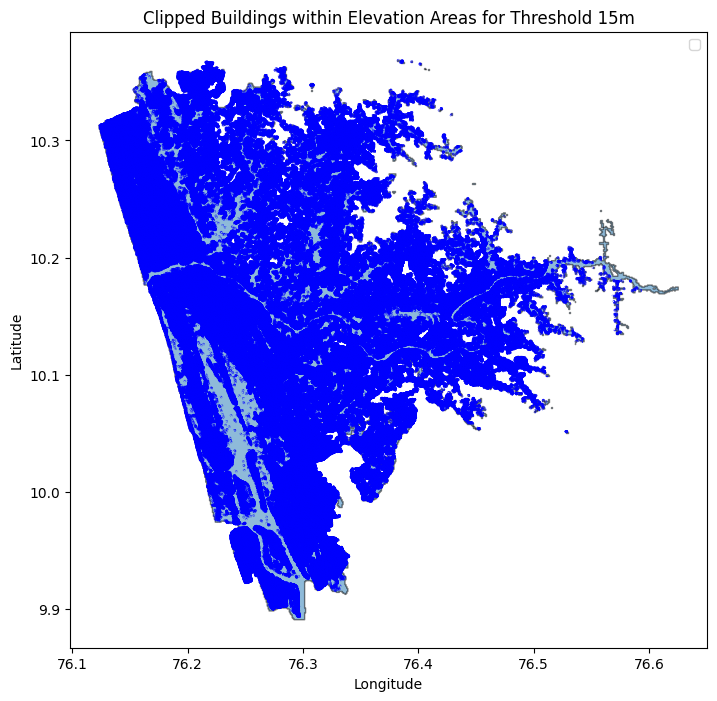

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

def clip_buildings_within_elevation(thresholds, elevation_shp_path, buildings_shp_path):
    for threshold in thresholds:
        output_shp = f"/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"

        # Load the elevation shapefile (at or below threshold)
        elevation_shp = gpd.read_file(output_shp)

        # Load the buildings shapefile
        buildings_shp = gpd.read_file("/content/drive/MyDrive/Lowerbasin/wktlower_build.shp")

        # Perform the intersection operation to clip the buildings
        clipped_buildings = gpd.overlay(buildings_shp, elevation_shp, how='intersection')

        # Save the clipped buildings to a new shapefile
        clipped_buildings.to_file('/content/drive/MyDrive/Lowerbasin/clipped_buildings{threshold}.shp', driver='ESRI Shapefile')

        # Plot the original elevation and clipped buildings
        fig, ax = plt.subplots(figsize=(12, 8))

        # Plot the elevation areas
        elevation_shp.plot(ax=ax, edgecolor='black', alpha=0.5, label='Elevation Areas (≤ 15m)')

        # Plot the clipped buildings
        clipped_buildings.plot(ax=ax, edgecolor='blue', linewidth=2, label='Clipped Buildings', alpha=0.7)

        # Set the title and labels
        ax.set_title(f"Clipped Buildings within Elevation Areas for Threshold {threshold}m")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

        # Add a legend to the plot
        ax.legend()

        # Show the plot
        plt.show()

# Example usage
thresholds = [15]
elevation_shp_path = "/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"
buildings_shp_path = '/content/drive/MyDrive/Lowerbasin/wktlower_build.shp'  # Adjust the path as necessary

clip_buildings_within_elevation(thresholds, elevation_shp_path, buildings_shp_path)

In [ ]:
import geopandas as gpd
from tabulate import tabulate

def count_buildings_within_boundaries(clipped_buildings_path, boundaries_shapefile_path):
    # Load the clipped buildings shapefile
    clipped_buildings = gpd.read_file(clipped_buildings_path)

    # Load the boundaries shapefile (Shapefile 2)
    boundaries = gpd.read_file(boundaries_shapefile_path)

    # Prepare a list to store results
    results = []

    # Iterate over each polygon in the boundaries shapefile
    for index, boundary in boundaries.iterrows():
        polygon = boundary.geometry
        polygon_name = boundary['name']  # Adjust if necessary to match the actual column name

        # Count buildings that intersect with the polygon
        count = clipped_buildings[clipped_buildings.intersects(polygon)].shape[0]

        # Append the result to the list
        results.append([index, polygon_name, count])

    # Print the results as a table
    print(tabulate(results, headers=["Index", "Polygon Name", "Count"], tablefmt="orgtbl"))

# Example usage
threshold = [15]
clipped_buildings_path = '/content/drive/MyDrive/Lowerbasin/clipped_buildings{threshold}.shp'  # Adjust the path as necessary
boundaries_shapefile_path = '/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp'  # Adjust the path as necessary

count_buildings_within_boundaries(clipped_buildings_path, boundaries_shapefile_path)

|   Index | Polygon Name                            |   Count |
|---------+-----------------------------------------+---------|
|       0 | Kochi                                   |  237484 |
|       1 | Kodassery                               |    1197 |
|       2 | Pariyaram                               |    3430 |
|       3 | Meloor                                  |    6573 |
|       4 | Koratty                                 |    7073 |
|       5 | Aloor                                   |    9475 |
|       6 | Chalakudy                               |   19835 |
|       7 | Kadukutty                               |   12558 |
|       8 | Annamanada                              |   14040 |
|       9 | Kuzhur                                  |    9317 |
|      10 | Mala                                    |   13473 |
|      11 | Poyya                                   |    8838 |
|      12 | Kodungallur                             |   35920 |
|      13 | Eriyad                      

**Function**

<ipython-input-5-f3188c415af6>:31: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


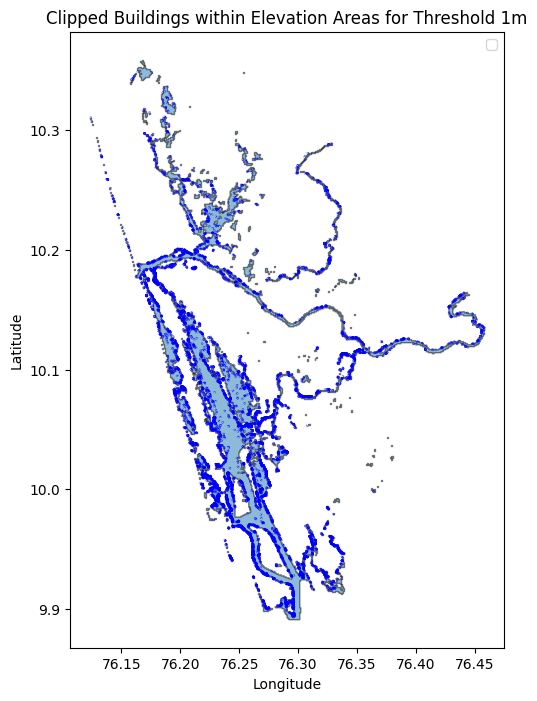

|   Index | Polygon Name                            |   Count |
|---------+-----------------------------------------+---------|
|       0 | Kochi                                   |    3131 |
|       1 | Kodassery                               |       0 |
|       2 | Pariyaram                               |       0 |
|       3 | Meloor                                  |       0 |
|       4 | Koratty                                 |       0 |
|       5 | Aloor                                   |       0 |
|       6 | Chalakudy                               |       8 |
|       7 | Kadukutty                               |      61 |
|       8 | Annamanada                              |      35 |
|       9 | Kuzhur                                  |      33 |
|      10 | Mala                                    |      29 |
|      11 | Poyya                                   |      74 |
|      12 | Kodungallur                             |     356 |
|      13 | Eriyad                      

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from tabulate import tabulate

def process_buildings_within_elevation_and_boundaries(thresholds, elevation_shp_path, buildings_shp_path, boundaries_shapefile_path):
    for threshold in thresholds:
        output_shp = f"/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"

        # Load the elevation shapefile (at or below threshold)
        elevation_shp = gpd.read_file(output_shp)

        # Load the buildings shapefile
        buildings_shp = gpd.read_file(buildings_shp_path)

        # Perform the intersection operation to clip the buildings
        clipped_buildings = gpd.overlay(buildings_shp, elevation_shp, how='intersection')

        # Save the clipped buildings to a new shapefile
        clipped_buildings_path = f'/content/drive/MyDrive/Lowerbasin/clipped_buildings_{threshold}.shp'
        clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')

        # Plot the original elevation and clipped buildings
        fig, ax = plt.subplots(figsize=(12, 8))
        elevation_shp.plot(ax=ax, edgecolor='black', alpha=0.5, label='Elevation Areas (≤ {threshold}m)')
        clipped_buildings.plot(ax=ax, edgecolor='blue', linewidth=2, label='Clipped Buildings', alpha=0.7)

        # Set the title and labels
        ax.set_title(f"Clipped Buildings within Elevation Areas for Threshold {threshold}m")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend()
        plt.show()

        # Count buildings within boundaries
        count_buildings_within_boundaries(clipped_buildings_path, boundaries_shapefile_path)

def count_buildings_within_boundaries(clipped_buildings_path, boundaries_shapefile_path):
    # Load the clipped buildings shapefile
    clipped_buildings = gpd.read_file(clipped_buildings_path)

    # Load the boundaries shapefile (Shapefile 2)
    boundaries = gpd.read_file(boundaries_shapefile_path)

    # Prepare a list to store results
    results = []

    # Iterate over each polygon in the boundaries shapefile
    for index, boundary in boundaries.iterrows():
        polygon = boundary.geometry
        polygon_name = boundary['name']  # Adjust if necessary to match the actual column name

        # Count buildings that intersect with the polygon
        count = clipped_buildings[clipped_buildings.intersects(polygon)].shape[0]

        # Append the result to the list
        results.append([index, polygon_name, count])

    # Print the results as a table
    print(tabulate(results, headers=["Index", "Polygon Name", "Count"], tablefmt="orgtbl"))

# Example usage
thresholds = [1]
elevation_shp_path = "/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"
buildings_shp_path = '/content/drive/MyDrive/Lowerbasin/wktlower_build.shp'  # Adjust the path as necessary
boundaries_shapefile_path = '/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp'  # Adjust the path as necessary

process_buildings_within_elevation_and_boundaries(thresholds, elevation_shp_path, buildings_shp_path, boundaries_shapefile_path)

In [ ]:
import geopandas as gpd
from tabulate import tabulate

# Define the output shapefile path for shp2 based on the threshold
thresholds = [15]
for threshold in thresholds:
    output_shp = f"/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"

    # Load the shapefiles
    buildings_gdf = gpd.read_file('/content/drive/MyDrive/Lowerbasin/lower_build.shp')  # Buildings shapefile
    panchayat_gdf = gpd.read_file('/content/drive/MyDrive/Lowerbasin/selected_test.shp')  # Panchayat shapefile
    elevation_gdf = gpd.read_file(output_shp)  # Elevation threshold shapefile

    # Create a list to store the results
    results = []

    # Iterate over the polygons in the panchayat GeoDataFrame
    for i, panchayat in panchayat_gdf.iterrows():
        panchayat_geom = panchayat.geometry  # Get the geometry of the panchayat

        # Filter elevation geometries that intersect with the current panchayat
        elevation_within_panchayat = elevation_gdf[elevation_gdf.intersects(panchayat_geom)]

        # Initialize count of buildings
        count = 0

        # Check if there are elevation features within the panchayat
        if not elevation_within_panchayat.empty:
            # Filter buildings that intersect with the elevation geometries
            for _, elevation in elevation_within_panchayat.iterrows():
                elevation_geom = elevation.geometry

                # Count buildings that intersect with the elevation geometry
                count += buildings_gdf[buildings_gdf.intersects(elevation_geom)].shape[0]

        # Get the panchayat name
        polygon_name = panchayat['Name']  # Adjust if necessary

        # Append the result to the list
        results.append({
            'Panchayat Name': polygon_name,
            'Building Count': count
        })

    # Print the results as a table
    print(tabulate(results, headers="keys", tablefmt="orgtbl"))

KeyboardInterrupt: 

In [ ]:
import osgeo.ogr as ogr
import geopandas as gpd
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd

# Define the output shapefile path for shp2 based on the threshold
thresholds = [15]
for threshold in thresholds:
    output_shp = f"/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"

    # Load the shapefiles using GeoPandas
    buildings_gdf = gpd.read_file('/content/drive/MyDrive/Lowerbasin/lower_build.shp')  # Buildings shapefile
    panchayat_gdf = gpd.read_file('/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp')  # Panchayat shapefile
    elevation_gdf = gpd.read_file(output_shp)  # Elevation threshold shapefile

    # Create a list to store the results
    results = []
    buildings_within_threshold = gpd.GeoDataFrame(columns=['Panchayat', 'Building'])

    # Iterate over the panchayat geometries
    for i, panchayat in panchayat_gdf.iterrows():
        panchayat_geom = panchayat.geometry
        count = 0

        # Clip buildings to the current panchayat geometry
        clipped_buildings = gpd.clip(buildings_gdf, panchayat_geom)

        # Check for intersections with the elevation threshold
        for _, elevation in elevation_gdf.iterrows():
            elevation_geom = elevation.geometry

            # Find buildings that intersect with the elevation threshold
            intersecting_buildings = clipped_buildings[clipped_buildings.intersects(elevation_geom)]

            # Count and store the intersecting buildings
            count += len(intersecting_buildings)
            if not intersecting_buildings.empty:
                intersecting_buildings['Panchayat'] = panchayat['Name']
                buildings_within_threshold = pd.concat([buildings_within_threshold, intersecting_buildings], ignore_index=True)

        # Append the result to the list
        results.append([i, panchayat['Name'], count])

    # Print the results as a table
    print(tabulate(results, headers=["Index", "Panchayat Name", "Building Count"], tablefmt="orgtbl"))

    # Plotting the buildings within the elevation threshold
    if not buildings_within_threshold.empty:
        # Create a plot
        fig, ax = plt.subplots(figsize=(10, 10))
        buildings_within_threshold.plot(ax=ax, color='blue', markersize=5, label='Buildings within threshold')
        plt.legend()
        plt.title('Buildings within Elevation Threshold by Panchayat')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

In [ ]:
# lower
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefiles
# Define the output shapefile path for shp1 based on the threshold
thresholds = [15]
for threshold in thresholds:
    output_shp = f"/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"

    # Open the shapefiles
    shapefile1 = gpd.read_file(output_shp)  # Use the output_shp variable directly
# shapefile2 = gpd.read_file('/content/drive/MyDrive/Lowerbasin/lower_build.shp')
shapefile2 = gpd.read_file('/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp')

# Plot the shapefiles
fig, ax = plt.subplots(figsize=(12, 8))
shapefile1.plot(ax=ax, color='blue', edgecolor='black', alpha=0.3)  # Decrease the opacity of shapefile1
shapefile2.boundary.plot(ax=ax, edgecolor='red', linewidth=2)  # Plot the boundaries of shapefile2

# Set the title and labels
ax.set_title("Coastal Buildings and Boundaries")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

to extract for a panchayat

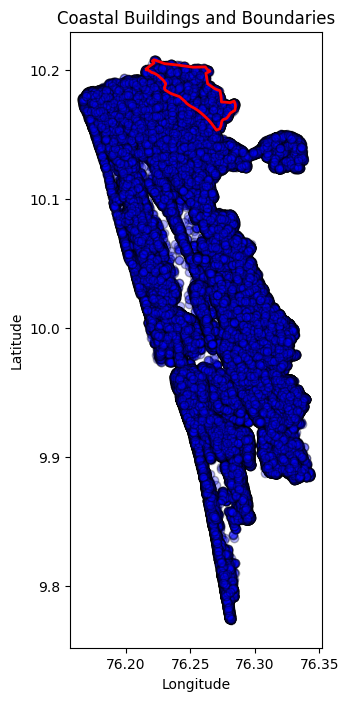

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefiles
shapefile1 = gpd.read_file('/content/drive/MyDrive/colab files/coastal_buildings1.shp')
shapefile2 = gpd.read_file('/content/drive/MyDrive/inundation/puthenvelikkara.shp')

# Plot the shapefiles
fig, ax = plt.subplots(figsize=(12, 8))
shapefile1.plot(ax=ax, color='blue', edgecolor='black', alpha=0.3)  # Decrease the opacity of shapefile1
shapefile2.boundary.plot(ax=ax, edgecolor='red', linewidth=2)  # Plot the boundaries of shapefile2

# Set the title and labels
ax.set_title("Coastal Buildings and Boundaries")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [ ]:
from osgeo import ogr

# Load the two shapefiles
shp1_ds = ogr.Open("/content/drive/MyDrive/colab files/coastal_buildings1.shp")
shp1_layer = shp1_ds.GetLayer(0)

shp2_ds = ogr.Open("/content/drive/MyDrive/inundation/puthenvelikkara.shp")
shp2_layer = shp2_ds.GetLayer(0)

# Create a new shapefile to store the extracted geometries
driver = ogr.GetDriverByName("ESRI Shapefile")
shp3_ds = driver.CreateDataSource("/content/drive/MyDrive/inundation/build_puthenveli.shp")
shp3_layer = shp3_ds.CreateLayer("shapefile3", geom_type=ogr.wkbPolygon)

# Add fields to the new shapefile (optional)
field_defn = ogr.FieldDefn("FID", ogr.OFTInteger)
shp3_layer.CreateField(field_defn)

# Create a list to store the geometries of shp1 that are within shp2
extracted_geometries = []

# Iterate through the features in shp2
for shp2_feature in shp2_layer:
    shp2_geometry = shp2_feature.GetGeometryRef()

    # Iterate through the features in shp1
    shp1_layer.ResetReading()  # Reset reading for shp1_layer
    for shp1_feature in shp1_layer:
        shp1_geometry = shp1_feature.GetGeometryRef()

        # Check if shp1 geometry is within shp2 geometry
        if shp1_geometry.Within(shp2_geometry):
            # If it is, store the geometry and its FID
            extracted_geometries.append({
                "FID": shp1_feature.GetFID(),
                "geometry": shp1_geometry.Clone()  # Clone the geometry for storage
            })

# Check if any geometries were extracted
if not extracted_geometries:
    print("No geometries found within the specified polygon.")
else:
    # Write the extracted geometries to the new shapefile
    for geom in extracted_geometries:
        new_feature = ogr.Feature(shp3_layer.GetLayerDefn())
        new_feature.SetField("FID", geom["FID"])
        new_feature.SetGeometry(geom["geometry"])
        shp3_layer.CreateFeature(new_feature)
        new_feature = None  # Clean up

    print(f"{len(extracted_geometries)} geometries written to build_puthenveli.shp")

# Clean up
shp1_ds = None
shp2_ds = None
shp3_ds = None

12536 geometries written to build_puthenveli.shp
